# Setup enviorment

In [ ]:
%cd ..

In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/ResNet50V2_Per_Band/224_band8.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

### Train Test split

In [5]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)


### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0    1         2         3         4    5    6    7    8  \
41001 201546 -1.0 -1.0 -0.962762 -0.802069 -0.875394 -1.0 -1.0 -1.0 -1.0   
      201547 -1.0 -1.0 -0.962762 -0.802069 -0.875394 -1.0 -1.0 -1.0 -1.0   
      201548 -1.0 -1.0 -0.962762 -0.802069 -0.875394 -1.0 -1.0 -1.0 -1.0   
      201549 -1.0 -1.0 -0.962762 -0.802069 -0.875394 -1.0 -1.0 -1.0 -1.0   
      201550 -1.0 -1.0 -0.962762 -0.802069 -0.875394 -1.0 -1.0 -1.0 -1.0   

                     9  ...  2039      2040      2041  2042  2043     2044  \
41001 201546 -0.953265  ...  -1.0 -0.869565 -0.922021  -1.0  -1.0 -0.73305   
      201547 -0.953265  ...  -1.0 -0.869565 -0.922021  -1.0  -1.0 -0.73305   
      201548 -0.953265  ...  -1.0 -0.869565 -0.922021  -1.0  -1.0 -0.73305   
      201549 -0.953265  ...  -1.0 -0.869565 -0.922021  -1.0  -1.0 -0.73305   
      201550 -0.953265  ...  -1.0 -0.869565 -0.922021  -1.0  -1.0 -0.73305   

              2045      2046  2047    Labels  
41001 201546  -1.0 -0.937446  -1.0 -0.861740  
      201547  -1.0 -0.937446  -1.0 -0.854589  
      201548  -1.0 -0.937446  -1.0 -0.856973  
      201549  -1.0 -0.937446  -1.0 -0.856973  
      201550  -1.0 -0.937446  -1.0 -0.823600  

[5 rows x 2049 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0         1         2    3         4    5         6  \
41001 201820 -1.000000 -0.941595 -0.819990 -1.0 -1.000000 -1.0 -0.936327   
      201821 -0.961554 -1.000000 -0.997586 -1.0 -1.000000 -1.0 -0.991534   
      201822  1.548908 -0.951237 -0.936756 -1.0 -0.993773 -1.0 -0.732478   
      201823 -1.000000 -0.929855 -0.611671 -1.0 -1.000000 -1.0 -1.000000   
      201824 -1.000000 -1.000000 -0.982490 -1.0 -0.306486 -1.0 -0.432695   

                     7         8         9  ...  2039      2040      2041  \
41001 201820 -1.000000 -0.902987 -0.735931  ...  -1.0  0.796421 -1.000000   
      201821 -0.188850 -1.000000 -0.923532  ...  -1.0 -0.602157 -0.972147   
      201822  0.218282 -0.932164 -1.000000  ...  -1.0 -0.757050 -1.000000   
      201823 -1.000000 -0.918102 -0.808006  ...  -1.0 -0.949974 -1.000000   
      201824 -1.000000 -0.984359 -0.998801  ...  -1.0 -0.800901 -0.836477   

              2042      2043      2044      2045      2046      2047    Labels  
41001 201820  -1.0 -0.911150 -1.000000 -1.000000 -0.993271 -1.000000 -0.949940  
      201821  -1.0 -0.949700 -1.000000 -1.000000 -0.565648 -0.584606 -0.961859  
      201822  -1.0 -0.929634 -0.901203 -1.000000 -0.390393 -0.755579 -0.940405  
      201823  -1.0 -1.000000 -1.000000 -0.963915 -1.000000 -1.000000 -0.961859  
      201824  -1.0 -0.921778 -1.000000 -1.000000 -0.279108 -0.970131 -0.954708  

[5 rows x 2049 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(130, 2049)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [11]:
train.shape

(1300, 2049)

### Features and Labels Set

In [12]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1300, 2048)
The shape of the labels is (1300, 1)
Test:
The shape of the features is (330, 2048)
The shape of the labels is (330, 1)


In [13]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

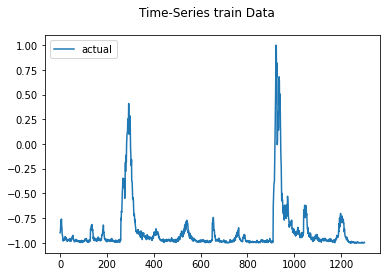

2023-03-07 14:49:35.849881: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-07 14:49:35.849924: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-07 14:49:35.849949: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-07 14:49:35.850150: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 14:49:36.067443: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 38.921
Test RMSE: 47.034
Test sMAPE: 103.140
Test R Squared: -1.289
{'mae': 38.920631344390635, 'rmse': 47.03369102469341, 'smape': 103.13979991257, 'r2': -1.2890755434522072}


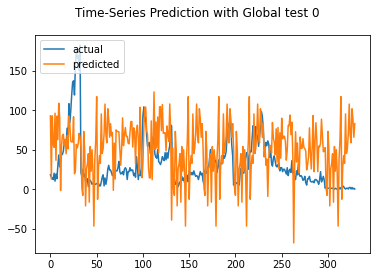

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 39.972
Test RMSE: 49.188
Test sMAPE: 115.190
Test R Squared: -1.504
{'mae': 39.972357733592844, 'rmse': 49.18828821812886, 'smape': 115.18958528920793, 'r2': -1.5036027498546014}


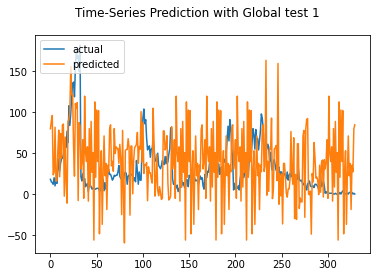

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 50.953
Test RMSE: 64.588
Test sMAPE: 126.818
Test R Squared: -3.317
{'mae': 50.95309229149963, 'rmse': 64.58809656473849, 'smape': 126.81768487406286, 'r2': -3.3166513577841954}


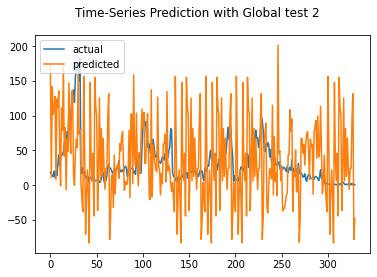

Test MAE: 36.372
Test RMSE: 46.167
Test sMAPE: 99.527
Test R Squared: -1.205
{'mae': 36.37199384335315, 'rmse': 46.166762743374726, 'smape': 99.52686340414095, 'r2': -1.2054684358129246}


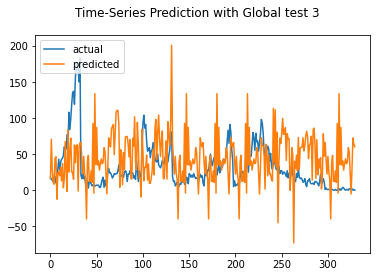

Test MAE: 47.261
Test RMSE: 74.932
Test sMAPE: 102.895
Test R Squared: -4.810
{'mae': 47.26122205528346, 'rmse': 74.93183489356981, 'smape': 102.89483737446777, 'r2': -4.809981328402904}


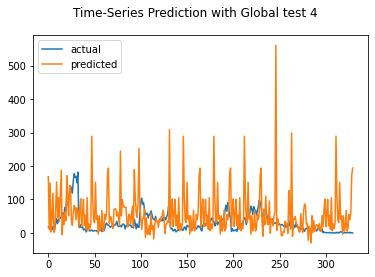

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 41.332
Test RMSE: 51.045
Test sMAPE: 105.738
Test R Squared: -1.696
{'mae': 41.3316141890757, 'rmse': 51.045239390667504, 'smape': 105.73799148871939, 'r2': -1.6962024032262524}


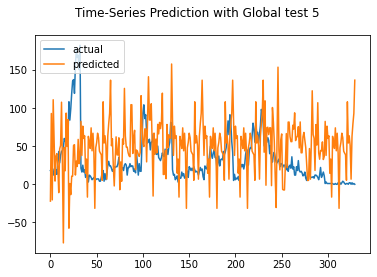

Test MAE: 59.451
Test RMSE: 82.323
Test sMAPE: 104.779
Test R Squared: -6.013
{'mae': 59.45065855546431, 'rmse': 82.32339054587347, 'smape': 104.77857513307434, 'r2': -6.012752300854239}


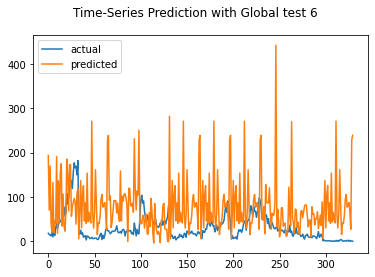

Test MAE: 116.353
Test RMSE: 166.465
Test sMAPE: 146.653
Test R Squared: -27.674
{'mae': 116.35326127698927, 'rmse': 166.46476358155513, 'smape': 146.65325275221613, 'r2': -27.673891547716316}


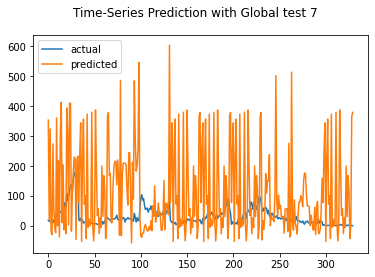

Test MAE: 69.341
Test RMSE: 78.280
Test sMAPE: 116.239
Test R Squared: -5.341
{'mae': 69.34091278711955, 'rmse': 78.27957830020856, 'smape': 116.23876229822773, 'r2': -5.3407255609253}


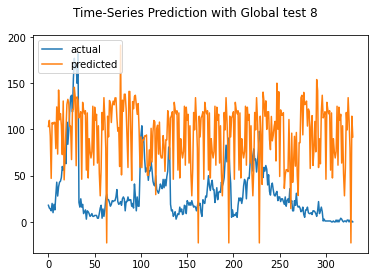

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 47.825
Test RMSE: 57.908
Test sMAPE: 116.471
Test R Squared: -2.470
{'mae': 47.82524756644711, 'rmse': 57.908338734353336, 'smape': 116.4711370641437, 'r2': -2.4699579662090465}


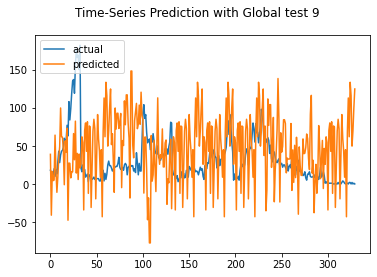

Test MAE: 54.764
Test RMSE: 68.778
Test sMAPE: 163.985
Test R Squared: -3.895
{'mae': 54.7638359068018, 'rmse': 68.77793016379694, 'smape': 163.98505874598035, 'r2': -3.8948592157857638}


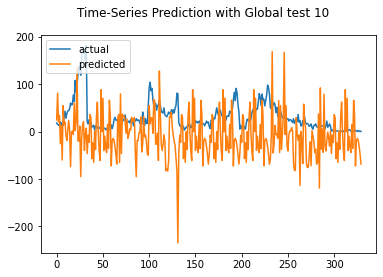

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 39.740
Test RMSE: 53.749
Test sMAPE: 117.144
Test R Squared: -1.989
{'mae': 39.740152923537025, 'rmse': 53.74948048057237, 'smape': 117.14446952487971, 'r2': -1.9894448335536952}


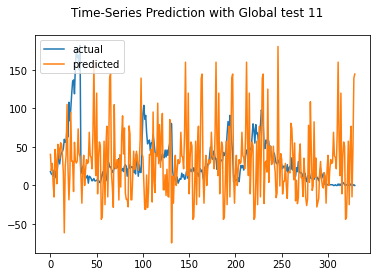

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Test MAE: 55.589
Test RMSE: 70.932
Test sMAPE: 136.433
Test R Squared: -4.206
{'mae': 55.589208620425424, 'rmse': 70.93246444333994, 'smape': 136.43288333922374, 'r2': -4.206334886188929}


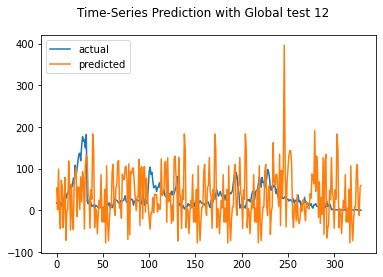

Test MAE: 59.354
Test RMSE: 70.893
Test sMAPE: 118.054
Test R Squared: -4.201
{'mae': 59.35434389042132, 'rmse': 70.89325560643077, 'smape': 118.05351607071321, 'r2': -4.2005807391110865}


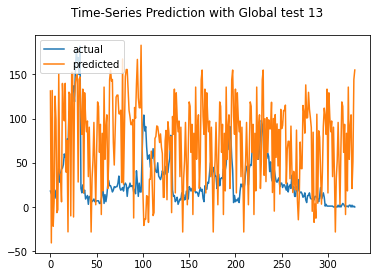

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 41.589
Test RMSE: 50.504
Test sMAPE: 105.437
Test R Squared: -1.639
{'mae': 41.588981194929644, 'rmse': 50.50398265127829, 'smape': 105.43713015872021, 'r2': -1.639327336485989}


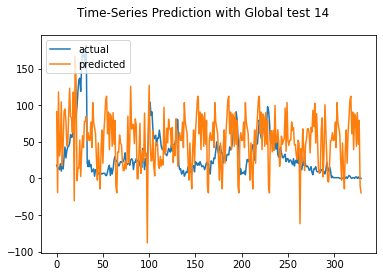

Test MAE: 74.928
Test RMSE: 91.315
Test sMAPE: 125.934
Test R Squared: -7.628
{'mae': 74.92801127433776, 'rmse': 91.31470090288174, 'smape': 125.93449690071778, 'r2': -7.628263577890467}


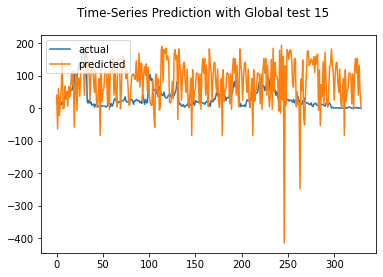

Test MAE: 60.212
Test RMSE: 75.582
Test sMAPE: 116.595
Test R Squared: -4.911
{'mae': 60.212438120264, 'rmse': 75.58225321316671, 'smape': 116.59459541812775, 'r2': -4.911281905260866}


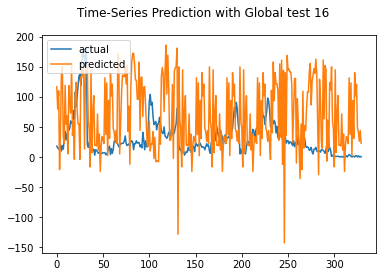

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 39.906
Test RMSE: 52.740
Test sMAPE: 117.296
Test R Squared: -1.878
{'mae': 39.906354615814756, 'rmse': 52.73955448212711, 'smape': 117.29577497142351, 'r2': -1.8781598809024387}


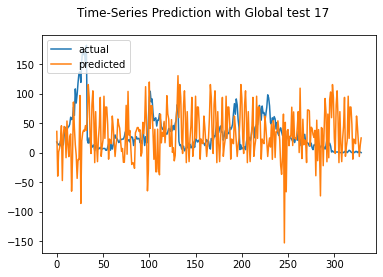

Test MAE: 63.072
Test RMSE: 72.490
Test sMAPE: 123.096
Test R Squared: -4.437
{'mae': 63.071534072991575, 'rmse': 72.49007029338637, 'smape': 123.09625650192527, 'r2': -4.437497163826675}


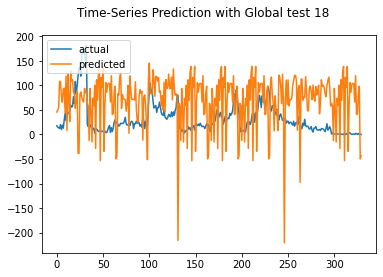

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 36.883
Test RMSE: 49.369
Test sMAPE: 107.871
Test R Squared: -1.522
{'mae': 36.88311222448493, 'rmse': 49.36926607082069, 'smape': 107.87076852300862, 'r2': -1.5220595899895044}


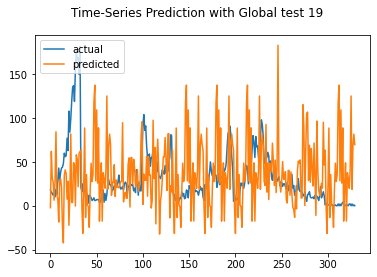

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 37.955
Test RMSE: 55.531
Test sMAPE: 115.856
Test R Squared: -2.191
{'mae': 37.955152014168824, 'rmse': 55.53073492679347, 'smape': 115.85575941948983, 'r2': -2.1908680401229583}


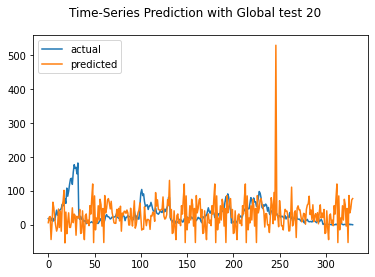

Test MAE: 43.843
Test RMSE: 54.546
Test sMAPE: 109.305
Test R Squared: -2.079
{'mae': 43.84301346630761, 'rmse': 54.545836245753925, 'smape': 109.3046145784355, 'r2': -2.0786846782728103}


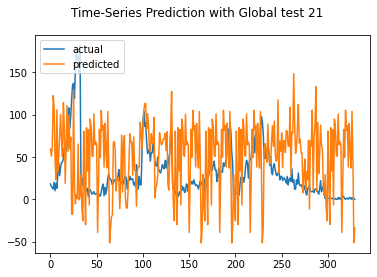

Test MAE: 44.774
Test RMSE: 55.020
Test sMAPE: 116.189
Test R Squared: -2.132
{'mae': 44.774042394666964, 'rmse': 55.02012260777081, 'smape': 116.18911976107978, 'r2': -2.1324569373268947}


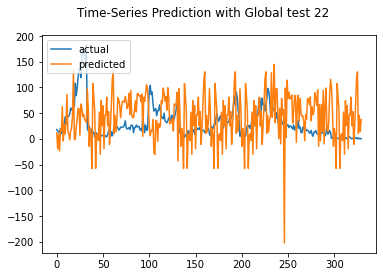

Test MAE: 71.851
Test RMSE: 79.783
Test sMAPE: 118.189
Test R Squared: -5.587
{'mae': 71.85108765616562, 'rmse': 79.78334676518898, 'smape': 118.18902039416619, 'r2': -5.5866790509093684}


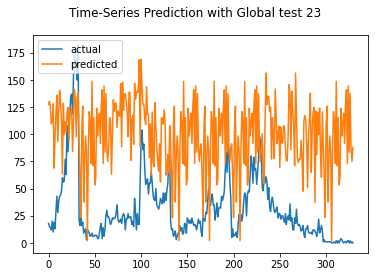

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 55.424
Test RMSE: 69.843
Test sMAPE: 124.513
Test R Squared: -4.048
{'mae': 55.42399295171102, 'rmse': 69.84336507051552, 'smape': 124.51295157901212, 'r2': -4.047685789128701}


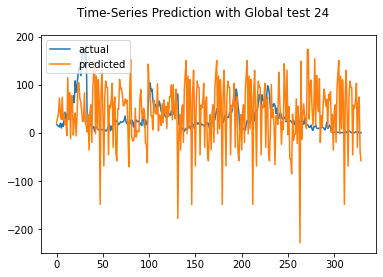

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 40.787
Test RMSE: 56.081
Test sMAPE: 125.970
Test R Squared: -2.254
{'mae': 40.78733362736124, 'rmse': 56.08072462237038, 'smape': 125.96970780875927, 'r2': -2.254387287250574}


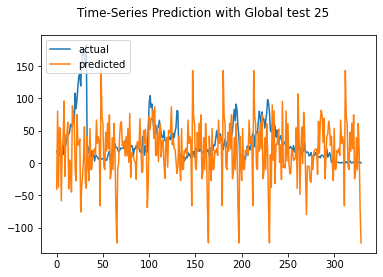

Test MAE: 36.946
Test RMSE: 45.382
Test sMAPE: 96.753
Test R Squared: -1.131
{'mae': 36.94602488821203, 'rmse': 45.38219361932657, 'smape': 96.75306344657149, 'r2': -1.1311448572014635}


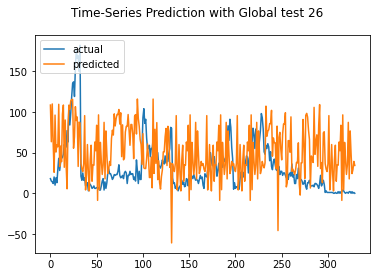

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 40.475
Test RMSE: 49.772
Test sMAPE: 94.298
Test R Squared: -1.563
{'mae': 40.47527177984064, 'rmse': 49.772203196256, 'smape': 94.29816930229855, 'r2': -1.56339617894516}


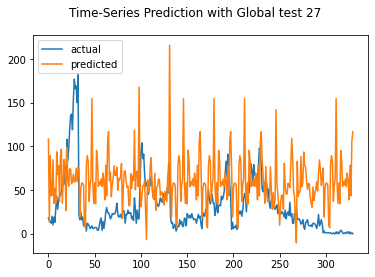

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 42.847
Test RMSE: 59.532
Test sMAPE: 107.324
Test R Squared: -2.667
{'mae': 42.84694964885712, 'rmse': 59.53200212391685, 'smape': 107.32410124108988, 'r2': -2.6672707859637432}


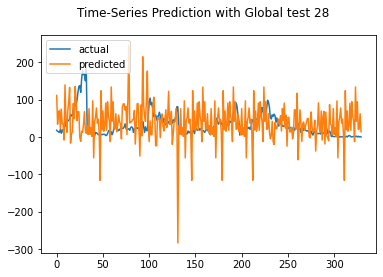

Test MAE: 39.983
Test RMSE: 54.662
Test sMAPE: 104.653
Test R Squared: -2.092
{'mae': 39.98336176818067, 'rmse': 54.66152842289274, 'smape': 104.65289740054408, 'r2': -2.091758360438052}


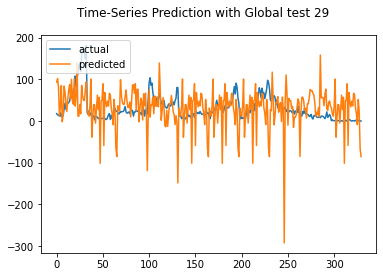

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 34.301
Test RMSE: 42.672
Test sMAPE: 90.570
Test R Squared: -0.884
{'mae': 34.301306169683286, 'rmse': 42.67225355471641, 'smape': 90.56998676949328, 'r2': -0.8842267254994978}


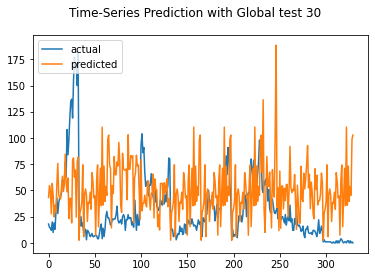

Test MAE: 70.057
Test RMSE: 89.562
Test sMAPE: 134.543
Test R Squared: -7.300
{'mae': 70.0573756920569, 'rmse': 89.56163442469868, 'smape': 134.54272833821318, 'r2': -7.300151560325064}


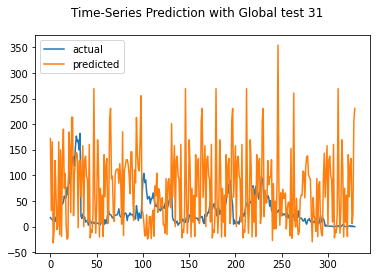

Test MAE: 45.083
Test RMSE: 54.101
Test sMAPE: 105.735
Test R Squared: -2.029
{'mae': 45.083476441195515, 'rmse': 54.101424444198905, 'smape': 105.7348605602218, 'r2': -2.028721924638914}


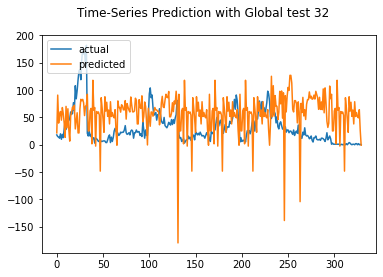

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 39.614
Test RMSE: 53.437
Test sMAPE: 100.197
Test R Squared: -1.955
{'mae': 39.61366947528088, 'rmse': 53.43659372040875, 'smape': 100.19715882383278, 'r2': -1.9547417910052465}


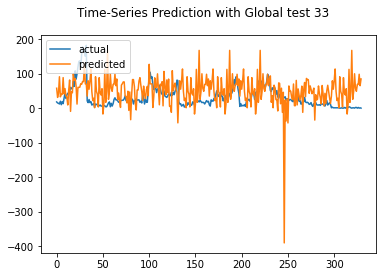

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 34.260
Test RMSE: 44.182
Test sMAPE: 102.715
Test R Squared: -1.020
{'mae': 34.26028714685729, 'rmse': 44.181524737026365, 'smape': 102.71490991760945, 'r2': -1.0198699162644131}


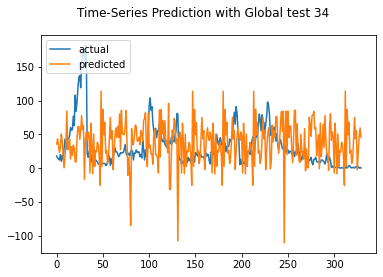

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 35.974
Test RMSE: 44.594
Test sMAPE: 97.097
Test R Squared: -1.058
{'mae': 35.974211714484476, 'rmse': 44.59383614111002, 'smape': 97.09688151548389, 'r2': -1.0577455401421125}


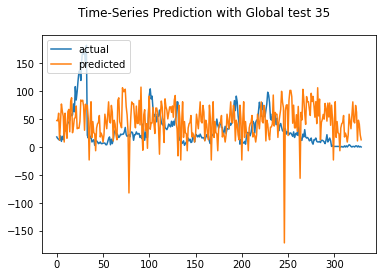

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 55.094
Test RMSE: 71.434
Test sMAPE: 119.197
Test R Squared: -4.280
{'mae': 55.09380152839603, 'rmse': 71.43367637087375, 'smape': 119.19686745971029, 'r2': -4.280171217821725}


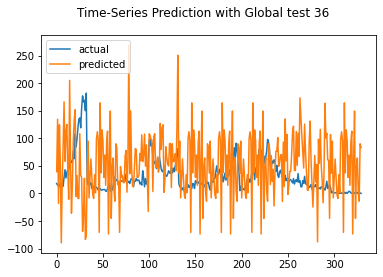

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 39.039
Test RMSE: 49.693
Test sMAPE: 105.099
Test R Squared: -1.555
{'mae': 39.039232316884124, 'rmse': 49.69325891888795, 'smape': 105.09931092833222, 'r2': -1.5552709621031702}


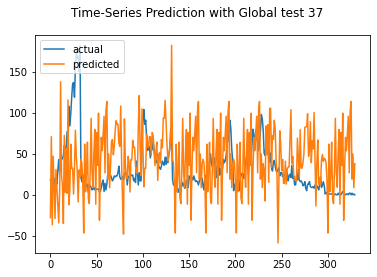

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 38.654
Test RMSE: 53.493
Test sMAPE: 106.284
Test R Squared: -1.961
{'mae': 38.654404958631055, 'rmse': 53.493427730086175, 'smape': 106.28406563371894, 'r2': -1.9610303328121717}


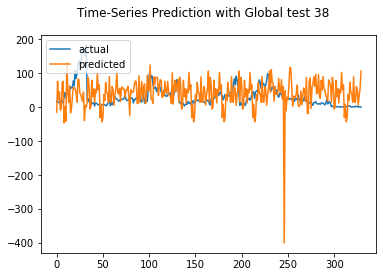

Test MAE: 65.578
Test RMSE: 73.669
Test sMAPE: 113.234
Test R Squared: -4.616
{'mae': 65.57803567250569, 'rmse': 73.66863607910112, 'smape': 113.23411475770986, 'r2': -4.615743462888211}


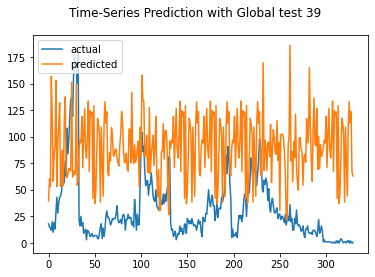

Test MAE: 57.014
Test RMSE: 70.725
Test sMAPE: 104.854
Test R Squared: -4.176
{'mae': 57.014263079383156, 'rmse': 70.72490452514486, 'smape': 104.85374558209834, 'r2': -4.175910301134706}


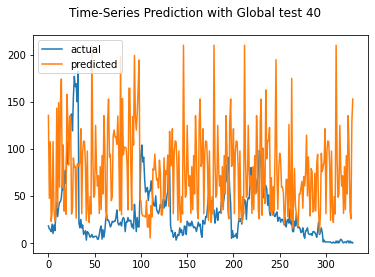

Test MAE: 44.049
Test RMSE: 53.829
Test sMAPE: 97.839
Test R Squared: -1.998
{'mae': 44.0488899230957, 'rmse': 53.828813357212276, 'smape': 97.8386881260891, 'r2': -1.998276036314945}


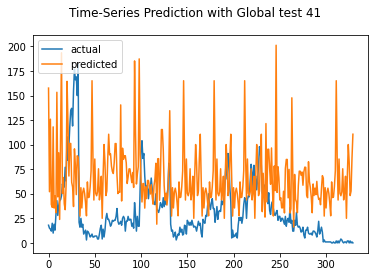

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 40.189
Test RMSE: 52.060
Test sMAPE: 98.370
Test R Squared: -1.805
{'mae': 40.18867276798595, 'rmse': 52.06043074558793, 'smape': 98.36965796750336, 'r2': -1.8045133773335769}


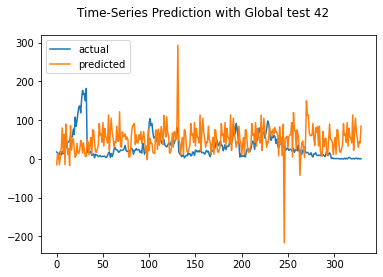

Test MAE: 40.983
Test RMSE: 61.758
Test sMAPE: 95.567
Test R Squared: -2.947
{'mae': 40.983469871318704, 'rmse': 61.75799122648732, 'smape': 95.56695581379076, 'r2': -2.9466473731622065}


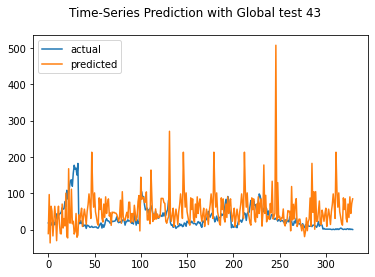

Test MAE: 81.270
Test RMSE: 93.584
Test sMAPE: 120.409
Test R Squared: -8.062
{'mae': 81.27041753349882, 'rmse': 93.58404744074298, 'smape': 120.40910155118132, 'r2': -8.062450554085693}


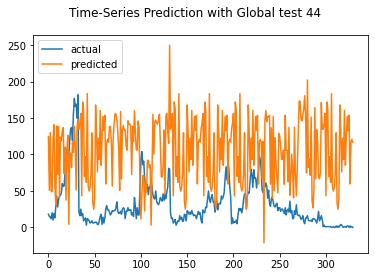

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 45.504
Test RMSE: 54.622
Test sMAPE: 111.946
Test R Squared: -2.087
{'mae': 45.503840673331055, 'rmse': 54.62232258617628, 'smape': 111.94630027791162, 'r2': -2.0873248399572844}


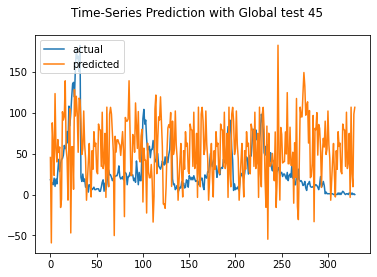

Test MAE: 50.571
Test RMSE: 58.349
Test sMAPE: 113.085
Test R Squared: -2.523
{'mae': 50.570985908219306, 'rmse': 58.34924881605129, 'smape': 113.08481644262808, 'r2': -2.5229991658172004}


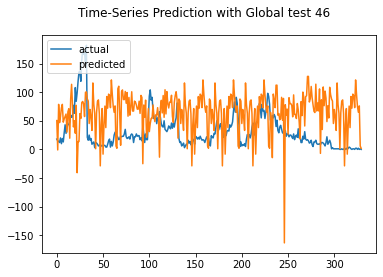

Test MAE: 49.876
Test RMSE: 77.149
Test sMAPE: 119.169
Test R Squared: -5.159
{'mae': 49.876413412437294, 'rmse': 77.14938086016029, 'smape': 119.16947026122077, 'r2': -5.158953027710032}


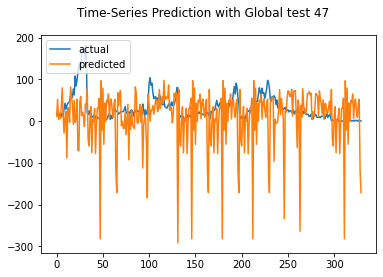

Test MAE: 63.150
Test RMSE: 76.590
Test sMAPE: 109.267
Test R Squared: -5.070
{'mae': 63.14954708706249, 'rmse': 76.59028778748164, 'smape': 109.26661126208677, 'r2': -5.070009970417506}


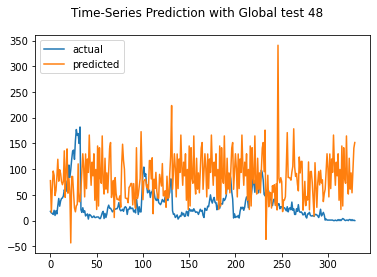

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 36.740
Test RMSE: 48.500
Test sMAPE: 113.363
Test R Squared: -1.434
{'mae': 36.74022468220104, 'rmse': 48.4995630297437, 'smape': 113.36290297681822, 'r2': -1.4339836305480076}


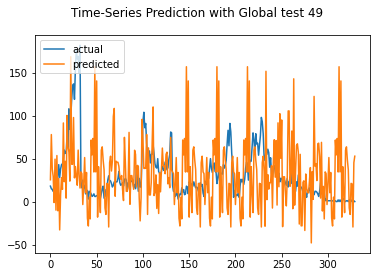

Test MAE: 32.538
Test RMSE: 42.462
Test sMAPE: 96.160
Test R Squared: -0.866
{'mae': 32.537935870343986, 'rmse': 42.46229474552997, 'smape': 96.1600769090257, 'r2': -0.8657305499489296}


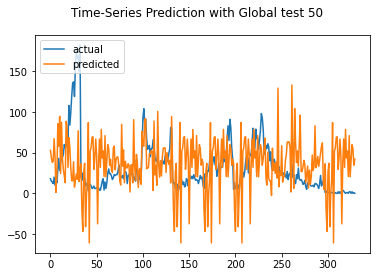

Test MAE: 51.089
Test RMSE: 61.834
Test sMAPE: 102.382
Test R Squared: -2.956
{'mae': 51.08886413863211, 'rmse': 61.833768729668385, 'smape': 102.38178327921601, 'r2': -2.9563384449303105}


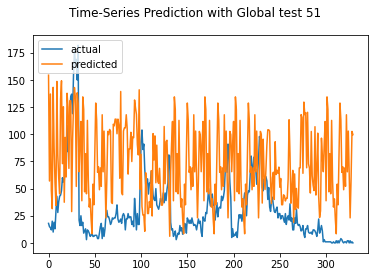

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 41.889
Test RMSE: 51.972
Test sMAPE: 101.731
Test R Squared: -1.795
{'mae': 41.88869476498979, 'rmse': 51.971972319124326, 'smape': 101.7310947492461, 'r2': -1.7949909023192245}


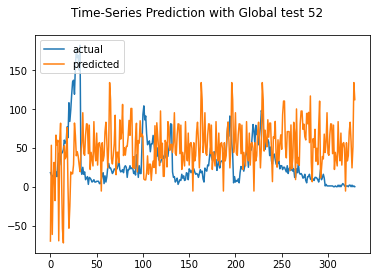

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 53.439
Test RMSE: 68.018
Test sMAPE: 115.149
Test R Squared: -3.787
{'mae': 53.4393372611566, 'rmse': 68.01821251734147, 'smape': 115.14900248046047, 'r2': -3.7873197023104215}


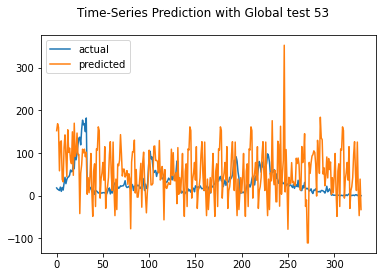

Test MAE: 59.608
Test RMSE: 76.885
Test sMAPE: 106.883
Test R Squared: -5.117
{'mae': 59.60809078559731, 'rmse': 76.88465219038335, 'smape': 106.88278360511805, 'r2': -5.116758156495581}


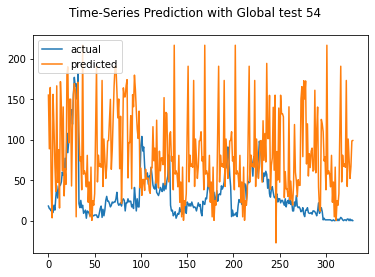

Test MAE: 65.308
Test RMSE: 92.848
Test sMAPE: 111.688
Test R Squared: -7.920
{'mae': 65.3084432936076, 'rmse': 92.84806902064176, 'smape': 111.68805520581876, 'r2': -7.920470344807722}


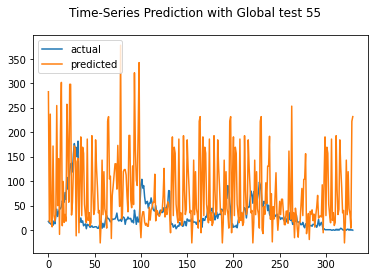

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 43.838
Test RMSE: 53.803
Test sMAPE: 105.335
Test R Squared: -1.995
{'mae': 43.838428086764885, 'rmse': 53.80297509325745, 'smape': 105.33494440452078, 'r2': -1.9953983338491539}


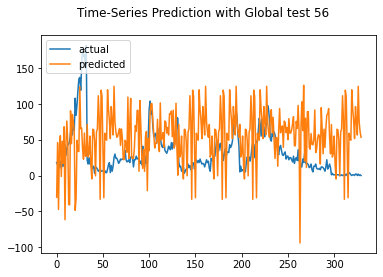

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 42.749
Test RMSE: 55.578
Test sMAPE: 109.605
Test R Squared: -2.196
{'mae': 42.74903075857596, 'rmse': 55.57757865475026, 'smape': 109.60475434577168, 'r2': -2.196253713454228}


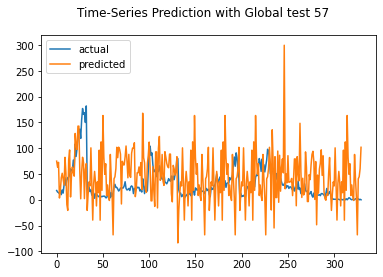

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 48.909
Test RMSE: 65.460
Test sMAPE: 121.487
Test R Squared: -3.434
{'mae': 48.90891079216292, 'rmse': 65.46015205827642, 'smape': 121.4865745864146, 'r2': -3.4340033946009783}


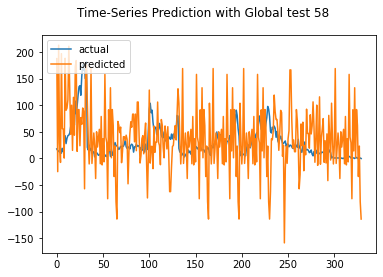

Test MAE: 83.928
Test RMSE: 92.878
Test sMAPE: 124.347
Test R Squared: -7.926
{'mae': 83.92796374234287, 'rmse': 92.87786704627011, 'smape': 124.34734405702588, 'r2': -7.926197013348387}


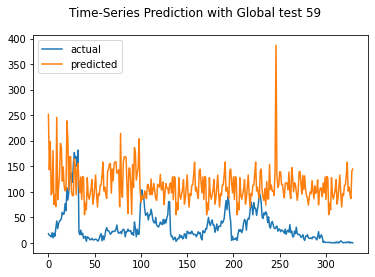

Test MAE: 38.473
Test RMSE: 53.996
Test sMAPE: 134.547
Test R Squared: -2.017
{'mae': 38.47316366723089, 'rmse': 53.99569935054312, 'smape': 134.54664354661247, 'r2': -2.01689602418977}


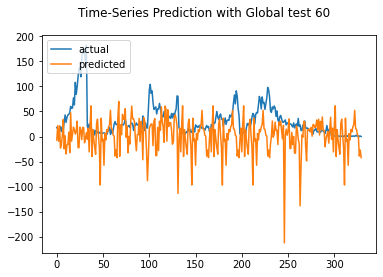

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 37.120
Test RMSE: 46.697
Test sMAPE: 103.210
Test R Squared: -1.256
{'mae': 37.120488245559464, 'rmse': 46.69724284107559, 'smape': 103.21037601680551, 'r2': -1.2564435854233214}


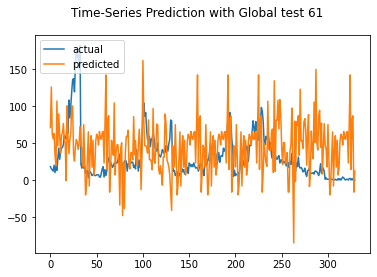

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 36.639
Test RMSE: 50.421
Test sMAPE: 116.857
Test R Squared: -1.631
{'mae': 36.638886057788675, 'rmse': 50.42079180602863, 'smape': 116.85684869438926, 'r2': -1.630639426229914}


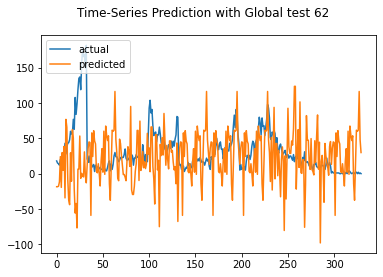

Test MAE: 62.712
Test RMSE: 82.589
Test sMAPE: 120.985
Test R Squared: -6.058
{'mae': 62.712077497713494, 'rmse': 82.5887492674677, 'smape': 120.98535200759572, 'r2': -6.058034550511247}


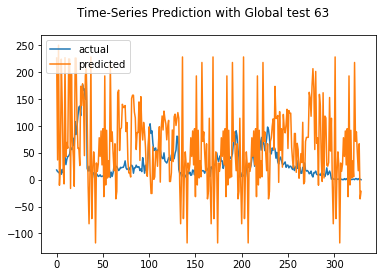

Test MAE: 49.211
Test RMSE: 64.430
Test sMAPE: 110.957
Test R Squared: -3.296
{'mae': 49.21055465178056, 'rmse': 64.4296740750969, 'smape': 110.95654230248549, 'r2': -3.2955014553184228}


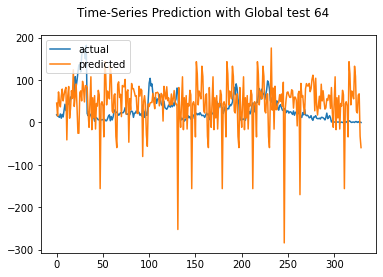

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 34.127
Test RMSE: 45.173
Test sMAPE: 121.865
Test R Squared: -1.112
{'mae': 34.12736006613934, 'rmse': 45.17321318855636, 'smape': 121.86503267697289, 'r2': -1.1115626334942195}


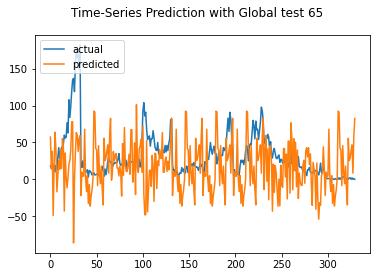

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 35.397
Test RMSE: 43.701
Test sMAPE: 95.591
Test R Squared: -0.976
{'mae': 35.39677834727547, 'rmse': 43.7008047452195, 'smape': 95.59099861434605, 'r2': -0.9761543865294009}


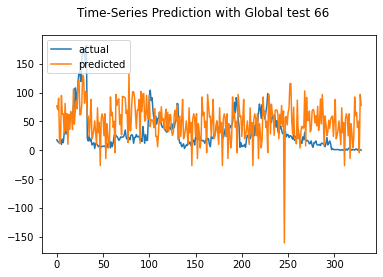

Test MAE: 79.782
Test RMSE: 102.817
Test sMAPE: 115.478
Test R Squared: -9.939
{'mae': 79.78198965824012, 'rmse': 102.81695704581487, 'smape': 115.47827035755829, 'r2': -9.938845653034813}


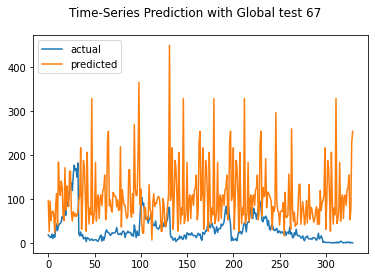

Test MAE: 73.137
Test RMSE: 93.204
Test sMAPE: 130.943
Test R Squared: -7.989
{'mae': 73.13668586376942, 'rmse': 93.20425244230617, 'smape': 130.94306757231269, 'r2': -7.989042973242798}


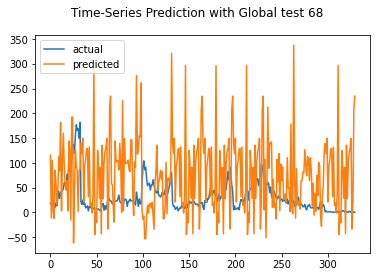

Test MAE: 54.833
Test RMSE: 68.543
Test sMAPE: 120.860
Test R Squared: -3.861
{'mae': 54.8330111422322, 'rmse': 68.54310987406383, 'smape': 120.85979059474529, 'r2': -3.8614924044880627}


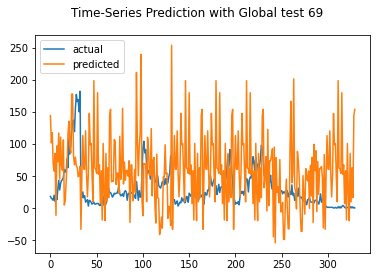

Test MAE: 50.289
Test RMSE: 61.114
Test sMAPE: 107.218
Test R Squared: -2.865
{'mae': 50.28915637514808, 'rmse': 61.11393858684971, 'smape': 107.2175421635155, 'r2': -2.8647601686143407}


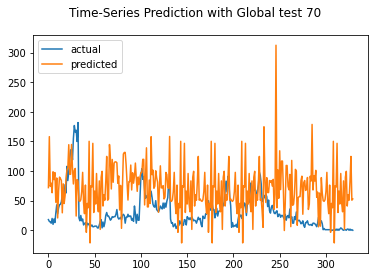

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 49.318
Test RMSE: 61.634
Test sMAPE: 117.103
Test R Squared: -2.931
{'mae': 49.31792796163848, 'rmse': 61.63437303160911, 'smape': 117.10337565542544, 'r2': -2.930863532617607}


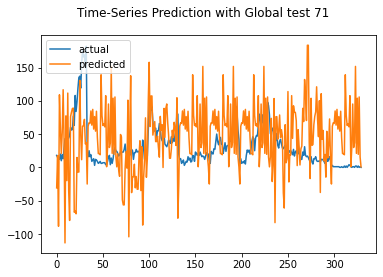

Test MAE: 67.787
Test RMSE: 82.861
Test sMAPE: 126.651
Test R Squared: -6.105
{'mae': 67.78727807113619, 'rmse': 82.86078846804753, 'smape': 126.65145268180817, 'r2': -6.104608069095051}


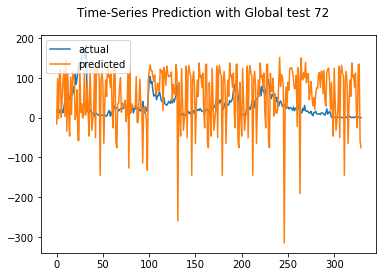

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 32.257
Test RMSE: 43.144
Test sMAPE: 88.319
Test R Squared: -0.926
{'mae': 32.2571946144104, 'rmse': 43.14428405413121, 'smape': 88.31901203532694, 'r2': -0.9261430361834522}


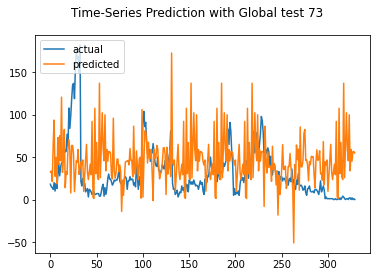

Test MAE: 60.508
Test RMSE: 73.487
Test sMAPE: 137.116
Test R Squared: -4.588
{'mae': 60.50767433896209, 'rmse': 73.48656433839018, 'smape': 137.1159860389216, 'r2': -4.588019190280517}


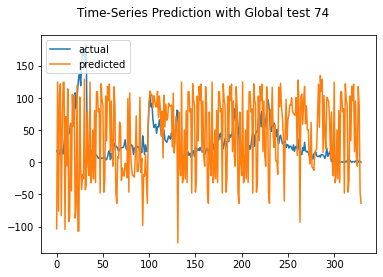

Test MAE: 39.771
Test RMSE: 49.551
Test sMAPE: 103.908
Test R Squared: -1.541
{'mae': 39.77104042732354, 'rmse': 49.55117141099005, 'smape': 103.9083940519165, 'r2': -1.5406793242651893}


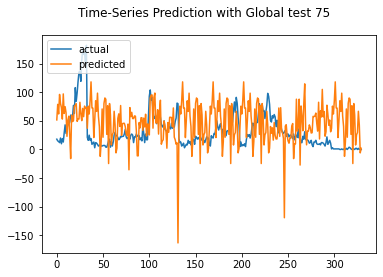

Test MAE: 74.848
Test RMSE: 118.737
Test sMAPE: 107.088
Test R Squared: -13.589
{'mae': 74.84783840034947, 'rmse': 118.7374997963346, 'smape': 107.08840790273386, 'r2': -13.58874057650498}


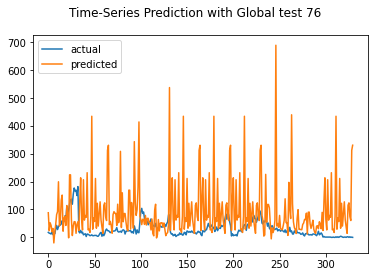

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 36.818
Test RMSE: 50.365
Test sMAPE: 118.558
Test R Squared: -1.625
{'mae': 36.81759781078859, 'rmse': 50.3652306450743, 'smape': 118.55757324667123, 'r2': -1.6248449575546418}


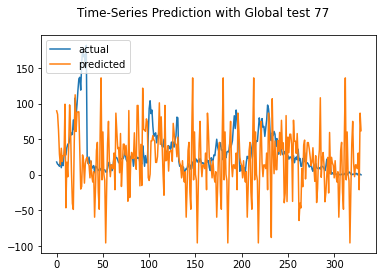

Test MAE: 77.826
Test RMSE: 112.309
Test sMAPE: 125.775
Test R Squared: -12.052
{'mae': 77.82610545971177, 'rmse': 112.30872748936609, 'smape': 125.77477030327397, 'r2': -12.051758060024476}


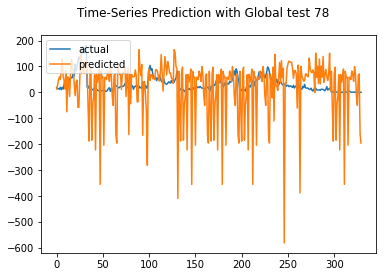

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 39.535
Test RMSE: 56.337
Test sMAPE: 105.328
Test R Squared: -2.284
{'mae': 39.535458777167584, 'rmse': 56.33686588671549, 'smape': 105.32782507186681, 'r2': -2.2841831402680404}


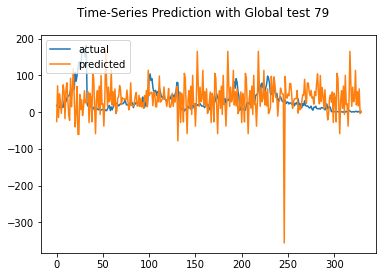

Test MAE: 81.953
Test RMSE: 108.751
Test sMAPE: 127.208
Test R Squared: -11.238
{'mae': 81.95270977851116, 'rmse': 108.75085781465906, 'smape': 127.20849152658792, 'r2': -11.237913643302313}


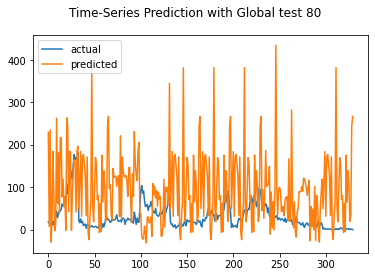

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 37.128
Test RMSE: 50.969
Test sMAPE: 114.327
Test R Squared: -1.688
{'mae': 37.12754083384167, 'rmse': 50.96880104855862, 'smape': 114.32707458744174, 'r2': -1.6881335241033564}


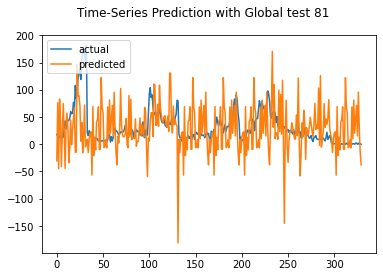

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 37.020
Test RMSE: 49.108
Test sMAPE: 111.706
Test R Squared: -1.495
{'mae': 37.020472610719274, 'rmse': 49.10849781514571, 'smape': 111.70580185496662, 'r2': -1.4954869378529212}


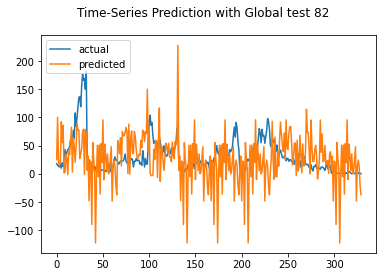

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 49.540
Test RMSE: 64.628
Test sMAPE: 114.884
Test R Squared: -3.322
{'mae': 49.5397829709631, 'rmse': 64.62753007070107, 'smape': 114.88421626351791, 'r2': -3.321923928714086}


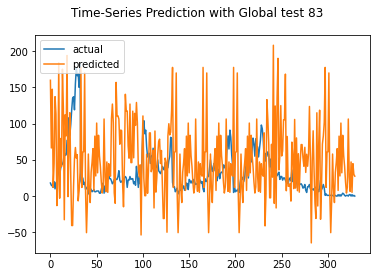

Test MAE: 38.297
Test RMSE: 46.449
Test sMAPE: 94.845
Test R Squared: -1.233
{'mae': 38.29655242508108, 'rmse': 46.448960791024604, 'smape': 94.84540424191134, 'r2': -1.2325130462696996}


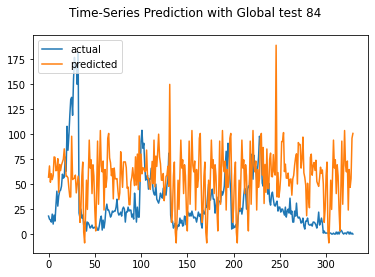

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 34.589
Test RMSE: 44.011
Test sMAPE: 100.222
Test R Squared: -1.004
{'mae': 34.58888104594115, 'rmse': 44.01099071601584, 'smape': 100.22174747853333, 'r2': -1.0043072227790835}


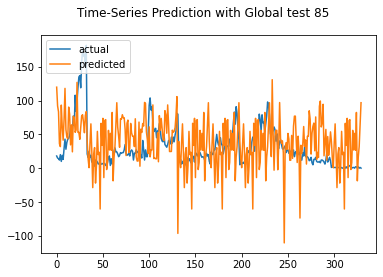

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 34.728
Test RMSE: 42.520
Test sMAPE: 105.099
Test R Squared: -0.871
{'mae': 34.72767605582873, 'rmse': 42.520321005416065, 'smape': 105.09896329908719, 'r2': -0.8708332104599477}


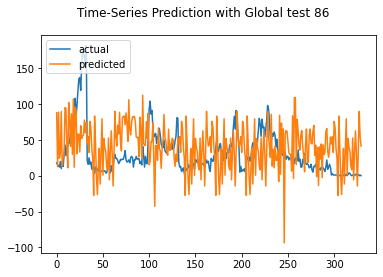

Test MAE: 55.481
Test RMSE: 79.757
Test sMAPE: 107.999
Test R Squared: -5.582
{'mae': 55.480885007074384, 'rmse': 79.75730246084193, 'smape': 107.99931002872715, 'r2': -5.582379470073907}


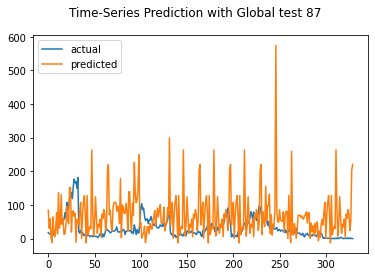

Test MAE: 46.671
Test RMSE: 58.862
Test sMAPE: 115.564
Test R Squared: -2.585
{'mae': 46.67086275120576, 'rmse': 58.86199157453541, 'smape': 115.56395895785742, 'r2': -2.5851877685450044}


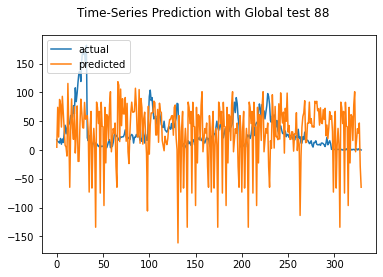

Test MAE: 56.461
Test RMSE: 67.545
Test sMAPE: 134.114
Test R Squared: -3.721
{'mae': 56.46058044776772, 'rmse': 67.5451102857785, 'smape': 134.11363295634845, 'r2': -3.720954686292628}


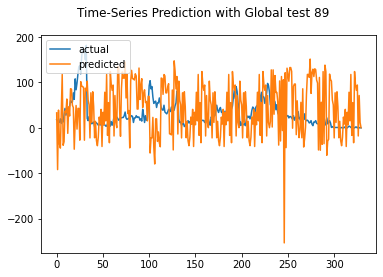

Test MAE: 102.391
Test RMSE: 147.545
Test sMAPE: 147.686
Test R Squared: -21.526
{'mae': 102.39079278057272, 'rmse': 147.54472903671257, 'smape': 147.6858538141916, 'r2': -21.526275949836172}


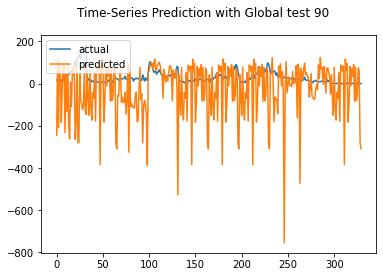

Test MAE: 67.087
Test RMSE: 111.777
Test sMAPE: 108.600
Test R Squared: -11.928
{'mae': 67.08687552231731, 'rmse': 111.77665836668075, 'smape': 108.59986664705886, 'r2': -11.92838407516384}


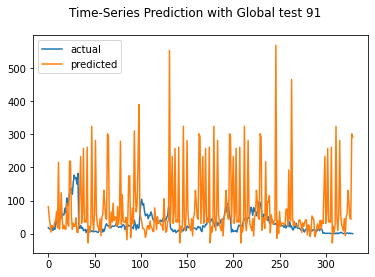

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 45.190
Test RMSE: 57.500
Test sMAPE: 113.246
Test R Squared: -2.421
{'mae': 45.18957752495101, 'rmse': 57.50035904560809, 'smape': 113.24593314751053, 'r2': -2.4212366418830467}


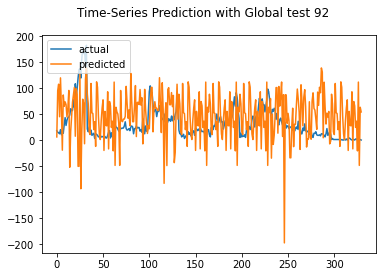

Test MAE: 69.553
Test RMSE: 76.028
Test sMAPE: 118.677
Test R Squared: -4.981
{'mae': 69.55315949411103, 'rmse': 76.02764874374309, 'smape': 118.67675973354723, 'r2': -4.9811558759315915}


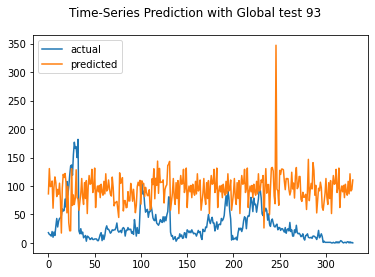

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Test MAE: 41.077
Test RMSE: 51.505
Test sMAPE: 109.257
Test R Squared: -1.745
{'mae': 41.07740802548148, 'rmse': 51.50463177492028, 'smape': 109.25687020846526, 'r2': -1.7449508645097986}


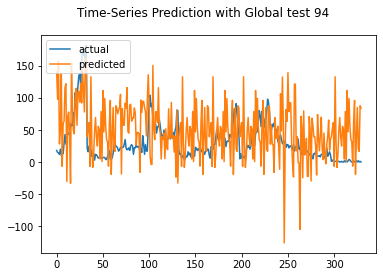

Test MAE: 110.249
Test RMSE: 184.520
Test sMAPE: 127.962
Test R Squared: -34.231
{'mae': 110.24883722428119, 'rmse': 184.51967331786537, 'smape': 127.96238640226407, 'r2': -34.23119350469174}


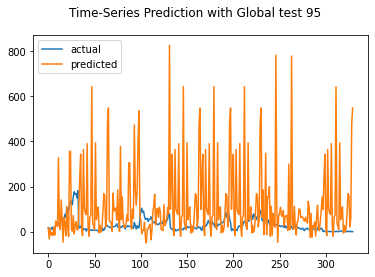

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 32.408
Test RMSE: 42.987
Test sMAPE: 105.217
Test R Squared: -0.912
{'mae': 32.40752584654273, 'rmse': 42.98694792137748, 'smape': 105.2166110692667, 'r2': -0.912120352677392}


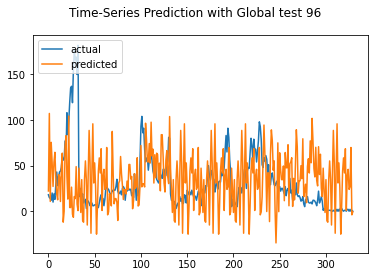

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 48.685
Test RMSE: 59.699
Test sMAPE: 119.311
Test R Squared: -2.688
{'mae': 48.68483101960385, 'rmse': 59.69925667655902, 'smape': 119.31067537689148, 'r2': -2.6879060523081275}


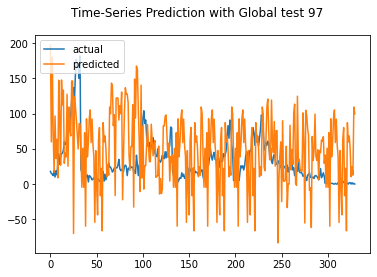

Test MAE: 55.566
Test RMSE: 72.639
Test sMAPE: 129.278
Test R Squared: -4.460
{'mae': 55.56614894144463, 'rmse': 72.63943397542607, 'smape': 129.27762323552037, 'r2': -4.4599278585397055}


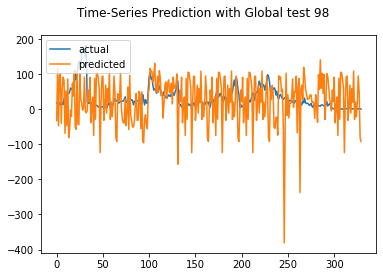

Test MAE: 67.731
Test RMSE: 82.822
Test sMAPE: 123.534
Test R Squared: -6.098
{'mae': 67.73112055243868, 'rmse': 82.82215600043683, 'smape': 123.53435231343526, 'r2': -6.09798480221604}


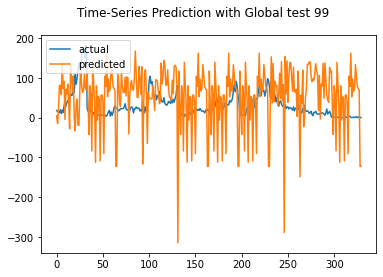

rmse : average=67.009, std=24.679
mae : average=51.612, std=16.745
smape : average=113.727, std=12.776
r2 : average=-4.277, std=4.995


([67.00907595562576, 24.678562591488696],
 [51.61193908524421, 16.744523768296766],
 [113.72741187943686, 12.775632197725718],
 [-4.276526351188604, 4.994977534630651])

In [14]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')